In [1]:
import os
import json
import csv
import sys
import numpy as np
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from tensorflow.keras.utils import plot_model
import datetime
import time
from tensorflow.keras.callbacks import TensorBoard

2023-05-04 12:10:32.231539: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Paths and declaration
audio_path = "./FMA Balanced"
csv_path = "csv_data.csv"

sr=22050

csv.field_size_limit(sys.maxsize)

131072

In [3]:
#All songs under 30 seconds
TOTAL_SAMPLES = 29 * sr

#Split the song in 3
NUM_SLICES = 3
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [4]:
#Write MFCC to CSV
def csv_write_data(audio_path, csv_path):
    #Create a list of rows for writing to CSV
    rows = []

    #Generate MFCC for every song & writing to CSV
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(audio_path)):
        for file in filenames:
            #Generate MFCC for every item in audio_path * slice
            song, sr = librosa.load(os.path.join(dirpath, file),duration=29)

            for s in range(NUM_SLICES):
                start_sample = SAMPLES_PER_SLICE * s
                end_sample = start_sample + SAMPLES_PER_SLICE
                
                
                mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=40)
                mfcc = mfcc.T

                rows.append([i-1,json.dumps(mfcc.tolist())])

        #Writing CSV
        with open(csv_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)

            # Write the header row
            writer.writerow(["genre", "mfcc"])

            # Write the values rows
            for row in rows:
                writer.writerow(row)

In [5]:
#Read MFCC data from CSV
def csv_read_data(csv_path):
    # Load data from CSV file
    with open(csv_path, 'r') as csvfile:
        reader = csv.reader(csvfile)

        next(reader)

        # Initialize lists to hold genre and MFCC data
        genres = []
        mfcc = []

        # Iterate over each row of the CSV file
        for row in reader:
            # Extract genre and MFCC data from the row
            genre = int(row[0])
            mfcc_data = json.loads(row[1])

            # Append genre and MFCC data to lists
            genres.append(genre)
            mfcc.append(mfcc_data)

    # Convert lists to numpy arrays
    X = np.array(mfcc)
    y = np.array(genres)

    return X, y

In [6]:
#Use stratified split to seperate data into training, validation and test

def stratified_split_dataset(inputs, targets, split_size):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=split_size, random_state=42)
    
    train_val_indices, test_indices = next(sss.split(inputs, targets))
    inputs_train_val, targets_train_val = inputs[train_val_indices], targets[train_val_indices]
    
    sss_train = StratifiedShuffleSplit(n_splits=1, test_size=split_size, random_state=43)
    train_indices, val_indices = next(sss_train.split(inputs_train_val, targets_train_val))
    
    inputs_train, targets_train = inputs_train_val[train_indices], targets_train_val[train_indices]
    inputs_val, targets_val = inputs_train_val[val_indices], targets_train_val[val_indices]
    inputs_test, targets_test = inputs[test_indices], targets[test_indices]
    
    #Needed for compatibility reasons
    inputs_train = inputs_train[...,np.newaxis]
    inputs_val = inputs_val[...,np.newaxis]
    inputs_test=  inputs_test[..., np.newaxis]
    
    
    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

In [15]:
#Design the model
def design_model(input_shape):
    
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

In [8]:
#Used to plot performance history of model
def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [9]:
#=============== MAIN ===============

#CSV WRITING DATA
csv_write_data(audio_path, csv_path)

In [10]:
#Reading MFCC data from CSV
inputs, targets = csv_read_data(csv_path)

In [11]:
#Splitting data
Xtrain, Xval, Xtest, ytrain, yval, ytest =stratified_split_dataset(inputs, targets, 0.2)

In [16]:
#Model Creation
input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
model = design_model(input_shape)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])

2023-05-04 12:10:59.823788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22250 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:81:00.0, compute capability: 8.6


In [22]:
#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 415, 38, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 208, 19, 64)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 208, 19, 64)      256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 206, 17, 64)       36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 103, 9, 64)       0         
 2D)                                                             
                                                        

In [17]:
#TENSORBOARD
NAME= "Final Version"
log_dir = "logs/fit/" + NAME
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [18]:
#COMPILATION
history = model.fit(Xtrain, ytrain,
                   validation_data = (Xval, yval),
                   epochs = 15,
                   batch_size = 64,
                   callbacks=[tensorboard_callback])

Epoch 1/15


2023-05-04 12:11:01.034813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-04 12:11:02.000143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-04 12:11:02.704844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-04 12:11:02.706143: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fe0c6dc0f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-04 12:11:02.706160: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-04 12:11:02.710435: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_uti

21/21 [==============================] - 5s 35ms/step - loss: 1.9201 - acc: 0.3475 - val_loss: 4.7497 - val_acc: 0.2560
Epoch 2/15
21/21 [==============================] - 0s 23ms/step - loss: 1.3210 - acc: 0.5045 - val_loss: 3.2636 - val_acc: 0.2827
Epoch 3/15
21/21 [==============================] - 0s 22ms/step - loss: 0.9974 - acc: 0.6153 - val_loss: 2.9248 - val_acc: 0.3185
Epoch 4/15
21/21 [==============================] - 0s 22ms/step - loss: 0.7149 - acc: 0.7396 - val_loss: 2.6424 - val_acc: 0.3542
Epoch 5/15
21/21 [==============================] - 0s 22ms/step - loss: 0.5168 - acc: 0.8304 - val_loss: 2.1787 - val_acc: 0.3452
Epoch 6/15
21/21 [==============================] - 0s 22ms/step - loss: 0.3119 - acc: 0.9174 - val_loss: 1.7571 - val_acc: 0.4613
Epoch 7/15
21/21 [==============================] - 0s 22ms/step - loss: 0.1776 - acc: 0.9591 - val_loss: 1.8806 - val_acc: 0.5089
Epoch 8/15
21/21 [==============================] - 0s 22ms/step - loss: 0.1116 - acc: 0.9814 

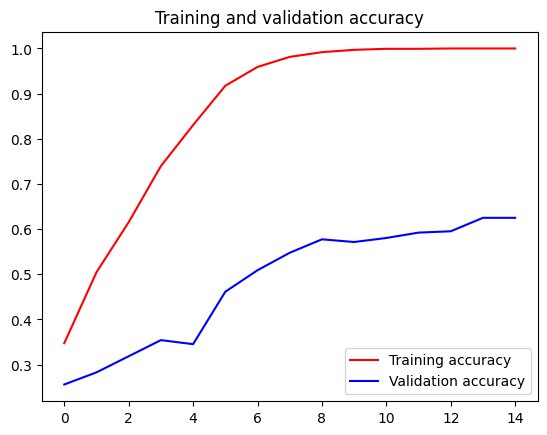

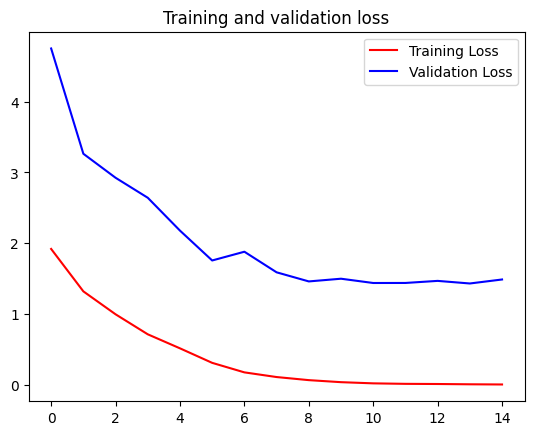

In [19]:
#Plot Performance
plot_performance(history)

In [20]:
model.save(NAME)

2023-05-04 12:11:12.700613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,51,4,64]
	 [[{{node inputs}}]]
2023-05-04 12:11:13.229436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,51,4,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: Random Sampler Re run4/assets


INFO:tensorflow:Assets written to: Random Sampler Re run4/assets


In [21]:
model.save(NAME+".h5", save_format='h5')